## import library

In [1]:
import time
import shutil
import pathlib
import itertools

In [2]:
import os
#store and extract features and other files 
import pickle
import numpy as np
from tqdm.notebook import tqdm

# use  Xception model to extract features from image 
from tensorflow.keras.applications.xception import Xception, preprocess_input
#preprocessing : load image and convert image to a numpys array in RGB format
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#preprocessing captions text
from tensorflow.keras.preprocessing.text import Tokenizer
#is used to ensure that all sequences in a list have the same length 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import matplotlib.pyplot as plt

import pandas as pd
#you can easily format and wrap long text lines into more readable paragraphs.
from textwrap import wrap
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
from tensorflow.keras.utils import Sequence

2024-03-09 17:50:07.594421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 17:50:07.594485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 17:50:07.595945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BASE_DIR = '/kaggle/input/dataset/Training'
TEST_DIR = '/kaggle/input/dataset/Testing'
WORKING_DIR = '/kaggle/working/'

In [4]:
from IPython.display import Image

In [5]:
data = pd.read_csv("../input/dataset/Training/captions.txt")
data

,image,caption
0,airport_1.jpg,Many aircraft are parked next to a long buildi...
1,airport_10.jpg,some planes are parked in an airport.the airpo...
2,airport_100.jpg,Many aircraft are parked in an airport near ma...
3,airport_101.jpg,Many aircraft are parked near a large building...
4,airport_102.jpg,several buildings and green trees are around a...
...,...,...
8729,00914.jpg,the majestic polygonal baseball field can cont...
8730,00915.jpg,the baseball field is near the residential are...
8731,00916.jpg,"on the side of the road, there are two basebal..."
8732,00918.jpg,this is a huge baseball field decorated with l...


In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/dataset/Training/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [7]:
# Load the Model
model = Xception()

# Restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [8]:
# extract features from image
features = {}
features_test = {}
directory = os.path.join(BASE_DIR, 'Images')
test_directory = os.path.join(TEST_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for Xception
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
for img_name in tqdm(os.listdir(test_directory)):
    # load the image from file
    img_path = test_directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for Xception
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features_test[image_id] = feature

  0%|          | 0/8734 [00:00<?, ?it/s]

  0%|          | 0/1093 [00:00<?, ?it/s]

In [9]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))
pickle.dump(features_test, open(os.path.join(WORKING_DIR, 'features_test.pkl'), 'wb'))

In [10]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)
with open(os.path.join(WORKING_DIR, 'features_test.pkl'), 'rb') as f:
    features_test = pickle.load(f)

In [11]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
with open(os.path.join(TEST_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc_test = f.read()

In [12]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

mapping_test = {}
# process lines
for line in tqdm(captions_doc_test.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping_test[image_id] = []
    # store the caption
    mapping_test[image_id].append(caption)

  0%|          | 0/8735 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

In [14]:
print(len(mapping))
print(len(mapping_test))

8734
1093


In [15]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [16]:
# preprocess the text
clean(mapping)
clean(mapping_test)

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
print(len(all_captions))
all_captions_test = []
for key in mapping_test:
    for caption in mapping_test[key]:
        all_captions_test.append(caption)
len(all_captions_test)

8734


1093

In [41]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
tokenizer.fit_on_texts(all_captions_test)
vocab_size_test = len(tokenizer.word_index) + 1
print(vocab_size_test)
vocab_size = max(vocab_size, vocab_size_test)
print(vocab_size)

2705
3203
3203


In [42]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)
max_length_test = max(len(caption.split()) for caption in all_captions_test)
print(max_length_test)

113
103


In [43]:
image_ids = list(mapping.keys())
train = image_ids
image_ids_test = list(mapping_test.keys())
test = image_ids_test

In [44]:
print(len(train))
print(len(test))

8734
1093


In [45]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [46]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# The BatchNormalization layer in Keras applies batch normalization to the input.
from tensorflow.keras.layers import Bidirectional, LSTM,BatchNormalization,Concatenate

In [47]:
# gc is the garbage collector module in Python. 
# It provides functions to manage the memory allocation and deallocation in your program
import gc


# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

# Decoder
decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

#Merge 2 networks
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [48]:
learning_rate = 0.001
#clipvalue: is a technique used to limit the magnitude of gradients during trainin
optimizer = Adam(learning_rate=learning_rate,clipvalue=5.0)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [49]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 113)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 113, 512)             1639936   ['input_7[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 2048)                 8192      ['input_6[0][0]']             
 chNormalization)                                                                           

In [50]:
from keras.callbacks import ModelCheckpoint

# Define hyperparameters
epochs = 50
batch_size = 32
step = len(train) // batch_size

# Define the checkpoint filepath
checkpoint_filepath = 'model_checkpoint.h5'

# Define the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Training loop
for epoch in range(epochs):
    # Create data generator for each epoch
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=step, verbose=1, callbacks=[model_checkpoint_callback])


272/272 [==============================] - 151s 557ms/step - loss: 0.0789 - accuracy: 0.9768


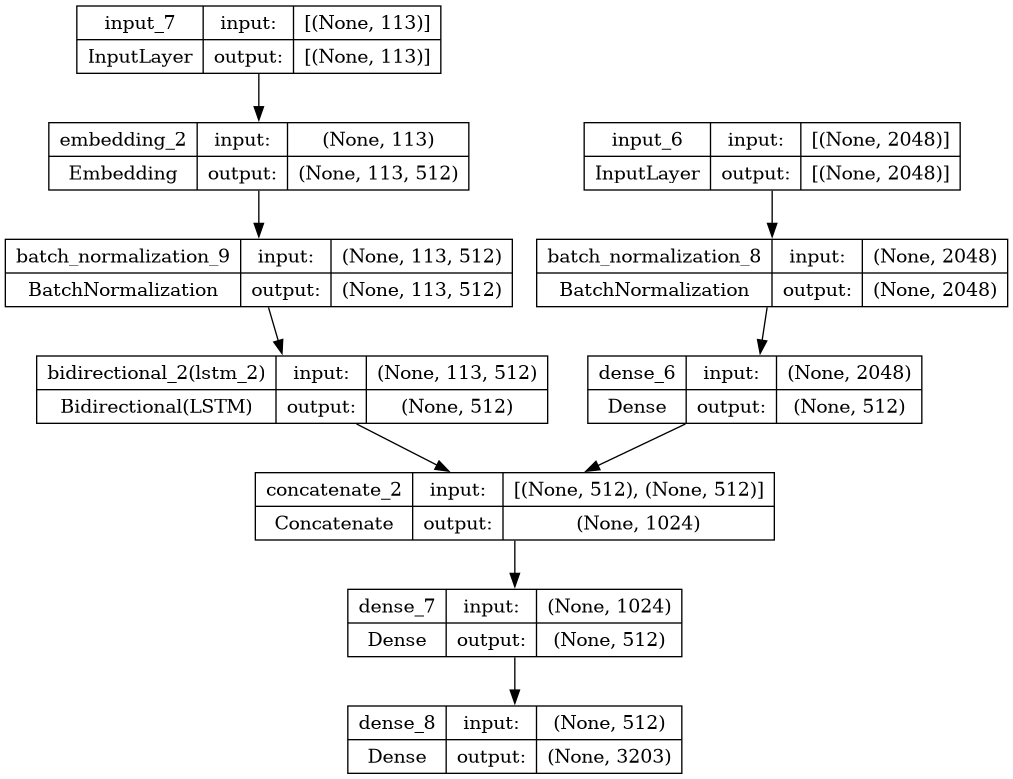

In [51]:
plot_model(model, show_shapes=True)

In [52]:
# save the model
model.save(WORKING_DIR + '/model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
def idx_to_word(integer, tokenizer):
    for word,index, in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [54]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [56]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping_test[key]
    # predict the caption for image
    y_pred = predict_caption(model, features_test[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 1093/1093 [1:41:14<00:00,  5.56s/it]


BLEU-1: 0.249144
BLEU-2: 0.111138


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
#     captions = mapping[image_id]
#     print('---------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)[8:][:-6]
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
import pickle
import tensorflow as tf
from keras.preprocessing.sequence import padsequences
from keras.preprocessing.image import img_to_array
import numpy as np

def generate_caption(input_features_file, model_path, tokenizer, max_length):
    model = tf.keras.models.load_model(model_path)
    with open(input_features_file, 'rb') as f:
        input_features = pickle.load(f)
    input_sequence = tokenizer.texts_to_sequences([input_features])[0]
    caption = generate_caption_sequence(model, input_sequence, max_length, tokenizer)
    return caption

def generate_caption_sequence(model, input_sequence, max_length, tokenizer):
    caption = ['<start>']
    for  in range(max_length):
        input_sequence = pad_sequences([input_sequence], maxlen=max_length)
        prediction = model.predict([input_sequence, np.array([caption])])
        predicted_index = np.argmax(prediction)
        predicted_word = tokenizer.index_word.get(predicted_index, '<unk>')
        if predicted_word == '<end>':
            break
        caption.append(predicted_word)
    generated_caption = ' '.join(caption[1:])
    return generated_caption

tokeniser = 'tokeniser.pkl'
input_features_file = 'features.pkl'
model_path = 'model.h5'
max_length = 50

caption = generate_caption(input_features_file, model_path, tokenizer, max_length)

print("Generated Caption:", caption)